In [1]:
%load_ext autoreload
%autoreload 2
'''
Example of how to use the library for learning using the PILCO learner on the cartpole task
'''
# pylint: disable=C0103
import atexit
import sys
import os
import numpy as np
import kusanagi.ghost.regression as kreg

from kusanagi import utils
from kusanagi.shell.cartpole import default_params
from kusanagi.ghost.learners.PILCO import PILCO, MC_PILCO
from kusanagi.ghost.control import NNPolicy
from kusanagi.utils import plot_results

#np.random.seed(31337)
np.set_printoptions(linewidth=500)

In [2]:
# setup output directory
utils.set_output_dir(os.path.join(utils.get_output_dir(), 'cartpole'))

use_bnn = True
J = 4                                                       # number of random initial trials
N = 100                                                     #learning iterations
pilco_config = default_params()
# initialize learner params for PILCO
pilco_config['params']['use_empirical_x0'] = True
pilco_config['params']['realtime'] = False
pilco_config['params']['H'] = 4.0
pilco_config['params']['plant']['dt'] = 0.1
pilco_config['params']['plant']['params']['l'] = .6
pilco_config['params']['cost']['pendulum_length'] = .6

# create copy of params for MC-PILCO
mcpilco_config = pilco_config.copy()
mcpilco_config['params']['min_method'] = 'ADAM'
mcpilco_config['params']['learning_rate'] = 1e-4
mcpilco_config['params']['max_evals'] = 1000
mcpilco_config['params']['clip'] = None
mcpilco_config['n_samples'] = 500
mcpilco_config['dynmodel_class'] = kreg.BNN
mcpilco_config['policy_class'] = NNPolicy

# init learners
pilco = PILCO(**pilco_config)
mcpilco = MC_PILCO(**mcpilco_config)
mcpilco.resample = False

# share experience and policy between the two learners
mcpilco.experience = pilco.experience
mcpilco.policy = pilco.policy

# gather data with random trials on the pilco learner
for i in range(J):
    pilco.plant.reset_state()
    pilco.apply_controller(random_controls=True)
#pilco.plant.reset_state()
#pilco.apply_controller()

[2017-05-18 12:50:45.654019] RBFPolicy_sat > Initializing parameters
[2017-05-18 12:50:45.659888] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-05-18 12:50:45.800879] RBFPolicy_sat > Initialising expression graph for prediction
[2017-05-18 12:50:45.814973] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-05-18 12:50:48.089799] RBFPolicy_sat > Done compiling
[2017-05-18 12:50:48.097954] Experience > Initialising new experience dataset
[2017-05-18 12:50:48.098781] PILCO > Initialising new PILCO learner
<class 'kusanagi.ghost.control.control_.NNPolicy'> True
[2017-05-18 12:50:48.102556] Experience > Initialising new experience dataset
[2017-05-18 12:50:48.103360] MC_PILCO > Initialising new MC_PILCO learner
[2017-05-18 12:50:48.105834] Cartpole > Reset to inital state
[2017-05-18 12:50:48.106790] PILCO > Compiling cost function
[2017-05-18 12:50:48.107720] PILCO > Cost parameters: {'target': [0, 0, 0, 3.141592653589793], 'width': 0.2

In [3]:
pilco.train_dynamics()

[2017-05-18 12:50:49.006345] PILCO > Training dynamics model
[2017-05-18 12:50:49.007320] GP_UI > Unable to load state from /home/juancamilog/.kusanagi/output/cartpole/PILCO_GP_UI_6_4_Cartpole_RBFPolicy_sat_dynamics.zip
[2017-05-18 12:50:49.009609] GP_UI > Initialising parameters
[2017-05-18 12:50:49.011316] PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-05-18 12:50:49.012307] GP_UI > Initialising expression graph for full GP training loss function
[2017-05-18 12:50:49.150709] GP_UI > Compiling full GP training loss function
[2017-05-18 12:50:49.620864] GP_UI > Compiling gradient of full GP training loss function
[2017-05-18 12:50:53.026347] GP_UI > Current hyperparameters:
[array([[-0.59279784, -0.09291971,  0.55902214, -1.22870238, -1.64559689,  1.04002834, -2.39670269, -4.69928779],
       [-0.59279784, -0.09291971,  0.55902214, -1.22870238, -1.64559689,  1.04002834, -0.9488638 , -3.25144889],
       [-0.59279784, -0.09291971,  0.55902214, -1.22870238, -1

In [4]:
mcpilco.train_dynamics(max_episodes=4)

[2017-05-18 12:50:53.925127] MC_PILCO > Training dynamics model
[2017-05-18 12:50:53.927065] BNN > Unable to load state from /home/juancamilog/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_NNPolicy_dynamics.zip
[2017-05-18 12:50:53.930377] MC_PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-05-18 12:50:53.931916] BNN > Building network
InputLayer {'shape': (None, 6), 'name': 'BNN_input'}
DenseLayer {'num_units': 200, 'nonlinearity': <function tanh at 0x7f48d14a1268>, 'name': 'BNN_fc0'}
DropoutLayer {'p': 0.1, 'rescale': False, 'name': 'BNN_drop0', 'dropout_samples': array(500, dtype=int32)}
DenseLayer {'num_units': 200, 'nonlinearity': <function tanh at 0x7f48d14a1268>, 'name': 'BNN_fc1'}
DropoutLayer {'p': 0.1, 'rescale': False, 'name': 'BNN_drop1', 'dropout_samples': array(500, dtype=int32)}
DenseLayer {'num_units': 4, 'nonlinearity': <function linear at 0x7f48d14a16a8>, 'name': 'BNN_output'}
[2017-05-18 12:50:53.943509] BNN > Initialising loss functio

[2017-05-18 12:51:16.086822] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 12:51:16.656375] MC_PILCO > Compiling trajectory rollout function
[2017-05-18 12:51:18.125678] MC_PILCO > Done compiling.


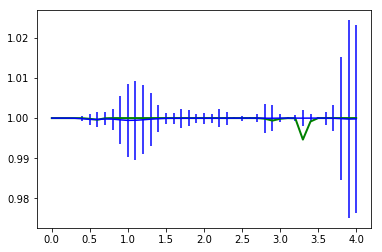

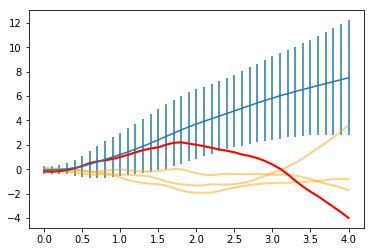

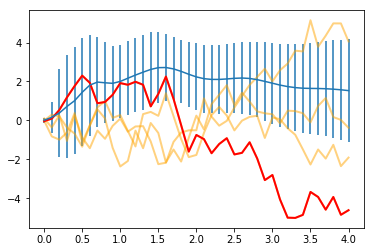

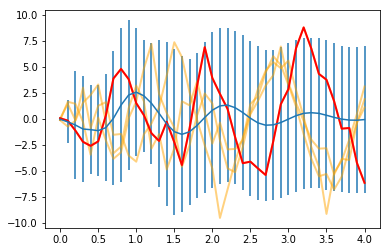

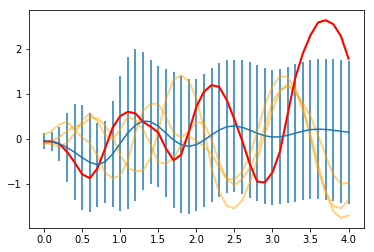

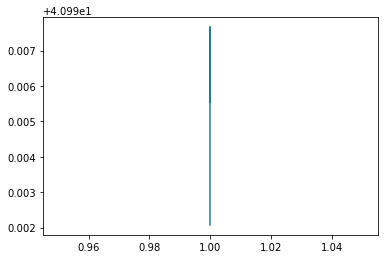

/home/juancamilog/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [5]:
mcpilco.resample = False
mcpilco.rollout_fn = None
mcpilco.set_n_samples(5000)
plot_results(mcpilco,plot_samples=False)

[2017-05-18 12:51:20.596832] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 12:51:21.225119] MC_PILCO > Compiling trajectory rollout function
[2017-05-18 12:51:22.850360] MC_PILCO > Done compiling.


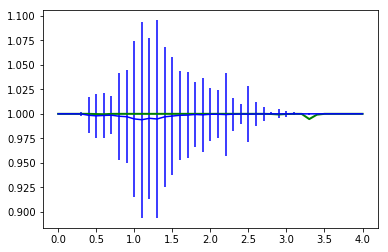

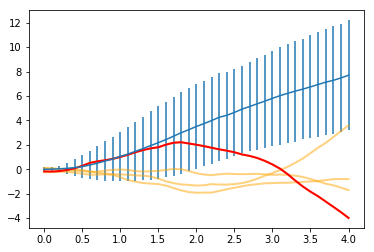

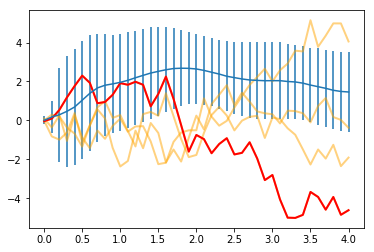

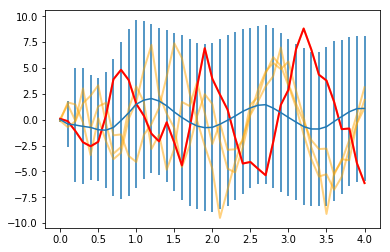

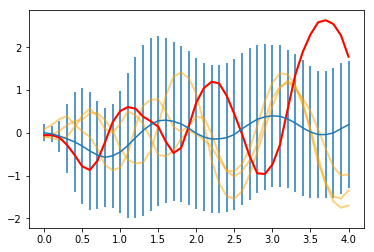

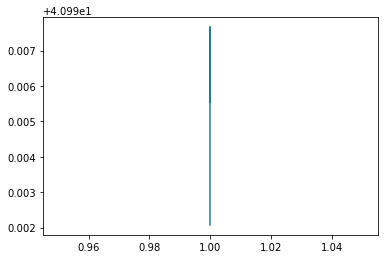

/home/juancamilog/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [6]:
mcpilco.resample = True
mcpilco.rollout_fn = None
mcpilco.set_n_samples(5000)
plot_results(mcpilco,plot_samples=False)

[2017-05-18 12:51:25.618650] PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 12:51:26.360462] PILCO > Compiling belief state propagation
[2017-05-18 12:51:32.550296] PILCO > Done compiling.
[2017-05-18 12:51:32.840796] plot_results > Predicted value: [40.980904]


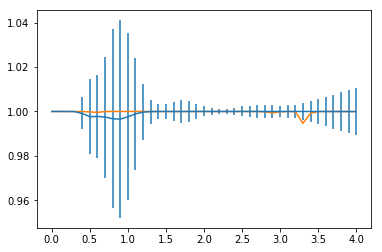

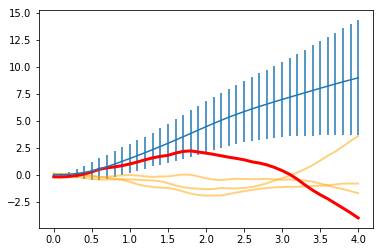

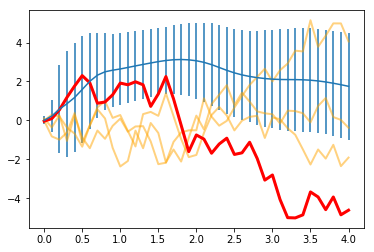

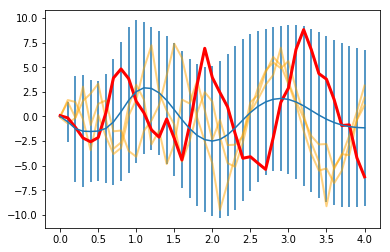

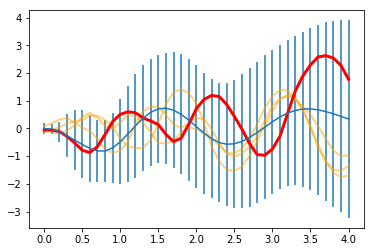

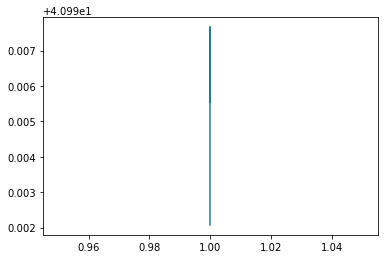

/home/juancamilog/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [7]:
plot_results(pilco)

In [8]:
resample = False
n_samples = 500
mcpilco.learning_rate = 1e-4
if mcpilco.trajectory_samples.get_value() != n_samples or mcpilco.resample != resample:
    mcpilco.resample = resample
    mcpilco.set_n_samples(n_samples)
    mcpilco.rollout_fn = None
    mcpilco.train_fn = None
# train
mcpilco.train_policy()
# apply controller
mcpilco.plant.reset_state()
mcpilco.apply_controller()

[2017-05-18 12:51:33.635462] MC_PILCO > Training policy parameters [Iteration 1]
[2017-05-18 12:51:33.643045] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 12:51:34.024346] MC_PILCO > Compiling trajectory rollout function
[2017-05-18 12:51:35.637011] MC_PILCO > Done compiling.
[2017-05-18 12:51:35.790210] MC_PILCO > Initial value estimate [39.996401]
[2017-05-18 12:51:35.791024] MC_PILCO > Using ADAM optimizer
[2017-05-18 12:51:35.791577] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 12:51:36.166244] MC_PILCO > Compiling optimizer
[2017-05-18 12:51:36.167367] MC_PILCO > Computing symbolic expression for policy gradients
[2017-05-18 12:51:57.341667] MC_PILCO > Done compiling.
[2017-05-18 13:04:14.207428] MC_PILCO > Current value: 3.999424E+01, Total evaluations: 1000, gm: [7169.800322725192, 1876.8711504786088, 522.77128284991466], lr: 0.0001000
[2017-05-18 13:04:14.366295] MC_PILCO > Done training. New 

In [9]:
mcpilco.save()

[2017-05-18 13:04:14.676497] RBFPolicy_sat > Saving state to /home/juancamilog/.kusanagi/output/cartpole/RBFPolicy_sat_5_1_cpu_float64.zip
[2017-05-18 13:04:14.889688] Experience > Saving state to /home/juancamilog/.kusanagi/output/cartpole/PILCO_GP_UI_6_4_Cartpole_RBFPolicy_sat_dataset.zip
[2017-05-18 13:04:15.157896] MC_PILCO > Saving state to /home/juancamilog/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_NNPolicy.zip
[2017-05-18 13:04:15.260000] BNN > Saving state to /home/juancamilog/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_NNPolicy_dynamics.zip
